# Week 5 Capstone - The Battle of Neighborhoods

## Introduction

In this project we will try to find an optimal location for a Japanese restaurant. Specifically, this report will be targeted to business staters interested in opening a Japanese restaurant in New York City, USA.

Since NYC has been considered the largest city in USA and also has been called "metropolis" for a long time, its neighborhood contains all kind of restaurants with different categories, such as Chinese, Indian, Italian food and etc, which provides me enough data and choices to do the analysis.

By using the data science powers, we could generate a list of neighborhoods descendingly based on the number of Japanese retaurants, which means we could find which borough has the largest potential Japanese restaurant market.

## Data

Based on definition of our problem, factors that will influence our decission are:

1. number of total existing restaurants in each borough (any type of restaurant);
2. number of Japanese restaurants in the neighborhood.

To find these specific factors, we will also use the New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.

## Methology

### 1. Libraries that will be used in the project

In [3]:
import numpy as np # library to handle data in a vectorized manner

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install geocoder
import geocoder
import os
!pip install folium
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

print('Libraries imported.')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 98 kB 8.9 MB/s  eta 0:00:01
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |██████████████████████████

### 2. Import and clean the data

In [8]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [9]:
neighborhoods=get_new_york_data()
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [10]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


### 3. Visualize and count the number of restaurants

Firstly, I tries to create a map of NYC, including its all boroughs.

In [54]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [56]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

After visualizing the restaurants in a map, I became curious about the total number of Japanese restaurant in each borough or neighborhood.

I then found the number of neighborhoods for each borough in NYC, as shown below.

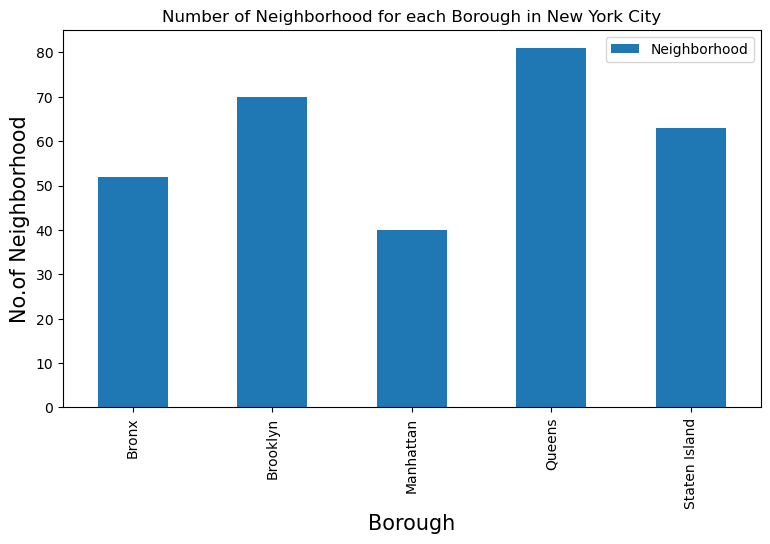

In [8]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
neighborhoods.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

From the barplot, we could find that Queens has the greatest number of neighborhoods.

Next, I will try to find the number of Japanese restaurant in each neighborhood.

In [11]:
CLIENT_ID = 'S3FYQHYMNS00ZJAN2MKXS243OEGMK2NKOH4OODVDNC5UDX11' # your Foursquare ID
CLIENT_SECRET = 'EHKEOBBXT3K13OW0E1ZZHGSUX4NNNVY22Q1BRB43PVNIWOVZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: xxxxxxxx' )
print('CLIENT_SECRET: xxxxxxxxxx' )

Your credentails:
CLIENT_ID: xxxxxxxx
CLIENT_SECRET: xxxxxxxxxx


In [12]:
def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [13]:
# queens has most neighborhoods
# prepare neighborhood list that contains japanese restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in neighborhoods.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_restaurants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(neighborhoods),')','Japanese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(japanese_restaurants)))
    for resturant_detail in japanese_restaurants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Japanese Restaurants in Wakefield, Bronx:0
( 2 / 306 ) Japanese Restaurants in Co-op City, Bronx:0
( 3 / 306 ) Japanese Restaurants in Eastchester, Bronx:0
( 4 / 306 ) Japanese Restaurants in Fieldston, Bronx:0
( 5 / 306 ) Japanese Restaurants in Riverdale, Bronx:0
( 6 / 306 ) Japanese Restaurants in Kingsbridge, Bronx:0
( 7 / 306 ) Japanese Restaurants in Marble Hill, Manhattan:0
( 8 / 306 ) Japanese Restaurants in Woodlawn, Bronx:0
( 9 / 306 ) Japanese Restaurants in Norwood, Bronx:0
( 10 / 306 ) Japanese Restaurants in Williamsbridge, Bronx:0
( 11 / 306 ) Japanese Restaurants in Baychester, Bronx:0
( 12 / 306 ) Japanese Restaurants in Pelham Parkway, Bronx:0
( 13 / 306 ) Japanese Restaurants in City Island, Bronx:0
( 14 / 306 ) Japanese Restaurants in Bedford Park, Bronx:0
( 15 / 306 ) Japanese Restaurants in University Heights, Bronx:0
( 16 / 306 ) Japanese Restaurants in Morris Heights, Bronx:0
( 17 / 306 ) Japanese Restaurants in Fordham, Bronx:0
( 18 / 306 ) Japanese

( 136 / 306 ) Japanese Restaurants in Forest Hills, Queens:0
( 137 / 306 ) Japanese Restaurants in Kew Gardens, Queens:0
( 138 / 306 ) Japanese Restaurants in Richmond Hill, Queens:0
( 139 / 306 ) Japanese Restaurants in Flushing, Queens:0
( 140 / 306 ) Japanese Restaurants in Long Island City, Queens:0
( 141 / 306 ) Japanese Restaurants in Sunnyside, Queens:0
( 142 / 306 ) Japanese Restaurants in East Elmhurst, Queens:0
( 143 / 306 ) Japanese Restaurants in Maspeth, Queens:0
( 144 / 306 ) Japanese Restaurants in Ridgewood, Queens:0
( 145 / 306 ) Japanese Restaurants in Glendale, Queens:0
( 146 / 306 ) Japanese Restaurants in Rego Park, Queens:2
( 147 / 306 ) Japanese Restaurants in Woodhaven, Queens:0
( 148 / 306 ) Japanese Restaurants in Ozone Park, Queens:0
( 149 / 306 ) Japanese Restaurants in South Ozone Park, Queens:0
( 150 / 306 ) Japanese Restaurants in College Point, Queens:0
( 151 / 306 ) Japanese Restaurants in Whitestone, Queens:0
( 152 / 306 ) Japanese Restaurants in Baysi

( 268 / 306 ) Japanese Restaurants in Claremont Village, Bronx:0
( 269 / 306 ) Japanese Restaurants in Concourse Village, Bronx:0
( 270 / 306 ) Japanese Restaurants in Mount Eden, Bronx:0
( 271 / 306 ) Japanese Restaurants in Mount Hope, Bronx:0
( 272 / 306 ) Japanese Restaurants in Sutton Place, Manhattan:0
( 273 / 306 ) Japanese Restaurants in Hunters Point, Queens:3
( 274 / 306 ) Japanese Restaurants in Turtle Bay, Manhattan:0
( 275 / 306 ) Japanese Restaurants in Tudor City, Manhattan:1
( 276 / 306 ) Japanese Restaurants in Stuyvesant Town, Manhattan:0
( 277 / 306 ) Japanese Restaurants in Flatiron, Manhattan:4
( 278 / 306 ) Japanese Restaurants in Sunnyside Gardens, Queens:1
( 279 / 306 ) Japanese Restaurants in Blissville, Queens:0
( 280 / 306 ) Japanese Restaurants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Japanese Restaurants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Japanese Restaurants in Weeksville, Brooklyn:0
( 283 / 306 ) Japanese Restaurants in Broadway Junction, Brooklyn

Now we have created a list of all Japanese restaurants in New York City and I decided to save the list into a cvs file called "japanese_rest_ny".

In [21]:
japanese_rest_ny.to_csv('japanese_rest_ny.csv')

In [15]:
from IPython.display import HTML
import pandas as pd
import base64, io

In [16]:
def create_download_link_csv(df, title = "Download CSV file", filename = "data.csv"):  
    # generate in-memory CSV, then base64-encode it
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [28]:
create_download_link_csv(japanese_rest_ny,"Download my data","japanese_rest_ny.csv.csv")

In [17]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_e4d1c7780d4f4ec19a30dd023b394f09 = 'https://s3-api.us-geo.objectstorage.softlayer.net'
else:
    endpoint_e4d1c7780d4f4ec19a30dd023b394f09 = 'https://s3-api.us-geo.objectstorage.service.networklayer.com'

client_e4d1c7780d4f4ec19a30dd023b394f09 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='eQ1Fw35t95tJcq3z1Q4dzF5SLC0SjHouEZjEME1GMAuE',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_e4d1c7780d4f4ec19a30dd023b394f09)

body = client_e4d1c7780d4f4ec19a30dd023b394f09.get_object(Bucket='ibmdatasciencecaptsone-donotdelete-pr-4aarzt9krj2tib',Key='japanese_rest_ny.csv.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

japanese_rest_ny = pd.read_csv(body)
japanese_rest_ny.head()


,Borough,Neighborhood,ID,Name
0,Brooklyn,Kensington,4d5c12a01e43236a87eb1583,Sake Sushi
1,Brooklyn,Williamsburg,51f9b7b3498eefe896caeb23,Shalom Japan
2,Brooklyn,Bedford Stuyvesant,5b3bcb69bfc6d0002ca9bf17,Warude
3,Brooklyn,Brooklyn Heights,479ccb47f964a5206b4d1fe3,Iron Chef House
4,Brooklyn,Cobble Hill,48a41073f964a52091511fe3,Hibino


In [18]:
#japanese_rest_ny = pd.read_csv('japanese_rest_ny.csv')
#japanese_rest_ny.tail()
#japanese_rest_ny.drop("Unnamed: 0", 1, inplace = True)
japanese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Brooklyn,Kensington,4d5c12a01e43236a87eb1583,Sake Sushi
1,Brooklyn,Williamsburg,51f9b7b3498eefe896caeb23,Shalom Japan
2,Brooklyn,Bedford Stuyvesant,5b3bcb69bfc6d0002ca9bf17,Warude
3,Brooklyn,Brooklyn Heights,479ccb47f964a5206b4d1fe3,Iron Chef House
4,Brooklyn,Cobble Hill,48a41073f964a52091511fe3,Hibino


In [19]:
japanese_rest_ny.shape

(57, 4)

From the dataframe, we could find that there are 57 Japanese restaurant in NYC. And the next step is to find the number of Japanese restaurant in each borough.

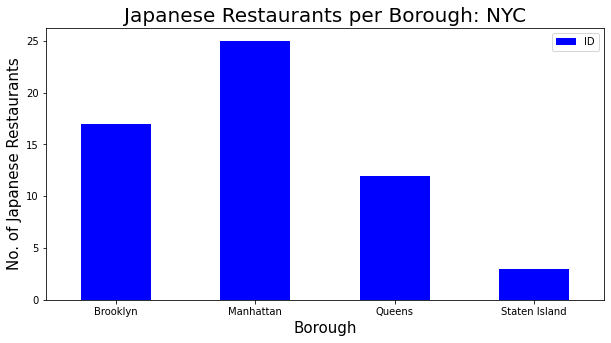

In [20]:
japanese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color='blue')
plt.title('Japanese Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

From the bar plot, Manhattan has the most Japanese restaurants. Besides this, I am also interested in which neighborhood contains the largest number of Japanese restaurants.

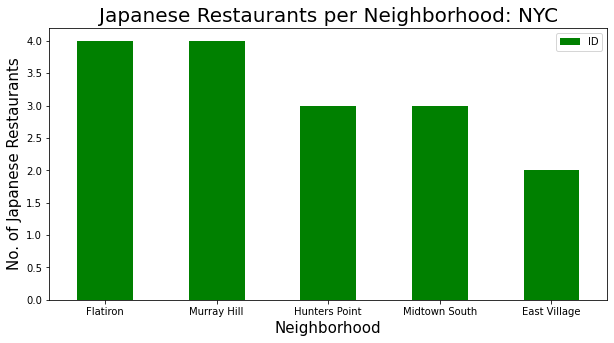

In [14]:
NoofNeigh = 5 # top number for graphing all the same past 5
japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NoofNeigh).plot.bar(figsize=(10,5), color="green")
plt.title('Japanese Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

From this plot, Flatiron and Murray Hill  have the same amount of Japanese restaurants.

In [15]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Murray Hill']

,Borough,Neighborhood,ID,Name
20,Manhattan,Murray Hill,4a99b4f4f964a520f62f20e3,Kajitsu
21,Manhattan,Murray Hill,559cbaa6498eaa4e8d884811,Tempura Matsui
22,Manhattan,Murray Hill,591caee89deb7d0f69be77a2,Omusubi Gonbei
23,Manhattan,Murray Hill,540dc46d498e86f0e5059dd2,Zuma New York


In [16]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Flatiron']

,Borough,Neighborhood,ID,Name
51,Manhattan,Flatiron,5bd7a5561c675b0039be9acc,HALL
52,Manhattan,Flatiron,4f7b61f6e4b07aaa5d524842,OOTOYA 大戸屋 (OOTOYA)
53,Manhattan,Flatiron,581a10901df6b32e66ec3a07,Sugarfish
54,Manhattan,Flatiron,55805bb5498e8356d675aa22,Yakiniku Futago


After we have a brief understanding of the Japanese restaurants in NYC, we also want to learn more about their rates and ranking so that we could find the best place for us to open a new Japanese restaurant.

In [7]:
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    # print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [10]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in japanese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name = row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(japanese_rest_ny),')','processed')
    japanese_rest_stats_ny = japanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
japanese_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '60c64c7ab155765a9948b94f'}, 'response': {'venue': {'id': '4d5c12a01e43236a87eb1583', 'name': 'Sake Sushi', 'contact': {'phone': '7188515299', 'formattedPhone': '(718) 851-5299'}, 'location': {'address': '328 Church Ave', 'crossStreet': 'East 4th Street', 'lat': 40.644138, 'lng': -73.976439, 'labeledLatLngs': [{'label': 'display', 'lat': 40.644138, 'lng': -73.976439}], 'postalCode': '11218', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['328 Church Ave (East 4th Street)', 'Brooklyn, NY 11218', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sake-sushi/4d5c12a01e43236a87eb1583', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 49}, 'url': 'http

{'meta': {'code': 200, 'requestId': '60c64c7af6a1442834ae58ad'}, 'response': {'venue': {'id': '51f9b7b3498eefe896caeb23', 'name': 'Shalom Japan', 'contact': {'phone': '7183884012', 'formattedPhone': '(718) 388-4012', 'twitter': 'shalomjapan'}, 'location': {'address': '310 S 4th St', 'crossStreet': 'at Rodney St', 'lat': 40.709219, 'lng': -73.955839, 'labeledLatLngs': [{'label': 'display', 'lat': 40.709219, 'lng': -73.955839}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['310 S 4th St (at Rodney St)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/shalom-japan/51f9b7b3498eefe896caeb23', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '52e81612bcbc57f1066b79fd', 'nam

{'meta': {'code': 200, 'requestId': '60c64c7a5928183be0d61fc2'}, 'response': {'venue': {'id': '5b3bcb69bfc6d0002ca9bf17', 'name': 'Warude', 'contact': {}, 'location': {'address': '387 Tompkins', 'lat': 40.684409678801586, 'lng': -73.94411847251774, 'labeledLatLngs': [{'label': 'display', 'lat': 40.684409678801586, 'lng': -73.94411847251774}], 'postalCode': '11216', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['387 Tompkins', 'New York, NY 11216', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/warude/5b3bcb69bfc6d0002ca9bf17', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss

{'meta': {'code': 200, 'requestId': '60c64c7c94ff2c281069a9f8'}, 'response': {'venue': {'id': '48a41073f964a52091511fe3', 'name': 'Hibino', 'contact': {'phone': '7182608052', 'formattedPhone': '(718) 260-8052', 'twitter': 'hibino_brooklyn', 'facebook': '301149720034179', 'facebookUsername': 'hibinobklyn', 'facebookName': 'Hibino Brooklyn'}, 'location': {'address': '333 Henry St', 'crossStreet': 'at Pacific St', 'lat': 40.69007601730789, 'lng': -73.99649744997076, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69007601730789, 'lng': -73.99649744997076}, {'label': 'entrance', 'lat': 40.690164, 'lng': -73.996383}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['333 Henry St (at Pacific St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hibino/48a41073f964a52091511fe3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Rest

{'meta': {'code': 200, 'requestId': '60c64c7c8eb53923beb05d45'}, 'response': {'venue': {'id': '5e4f270b03b7910008721f2e', 'name': 'Karazishi Botan', 'contact': {'phone': '3477631155', 'formattedPhone': '(347) 763-1155', 'instagram': 'karazishi_botan', 'facebook': '110365083873021', 'facebookUsername': 'KarazishiBotanBKLYN', 'facebookName': 'Karazishi Botan'}, 'location': {'address': '255 Smith St', 'crossStreet': 'Degraw St', 'lat': 40.683154, 'lng': -73.992888, 'labeledLatLngs': [{'label': 'display', 'lat': 40.683154, 'lng': -73.992888}], 'postalCode': '11231', 'cc': 'US', 'neighborhood': 'Boerum Hill', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['255 Smith St (Degraw St)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/karazishi-botan/5e4f270b03b7910008721f2e', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon'

{'meta': {'code': 200, 'requestId': '60c64c7cbfbfc40d2e795130'}, 'response': {'venue': {'id': '5276d39a498eb1a5d90096e4', 'name': 'Sushi Katsuei', 'contact': {'phone': '7187885338', 'formattedPhone': '(718) 788-5338', 'instagram': 'sushikatsuei', 'facebook': '566743240069984', 'facebookUsername': 'SushiKatsuei', 'facebookName': 'Sushi Katsuei'}, 'location': {'address': '210 7th Ave', 'crossStreet': 'at 3rd St', 'lat': 40.67061519402922, 'lng': -73.97850388946965, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67061519402922, 'lng': -73.97850388946965}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['210 7th Ave (at 3rd St)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sushi-katsuei/5276d39a498eb1a5d90096e4', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'htt

{'meta': {'code': 200, 'requestId': '60c64c7d3efa1124beaf7348'}, 'response': {'venue': {'id': '4e3cadcb1f6e844231dbe017', 'name': 'Waza', 'contact': {'phone': '7183999292', 'formattedPhone': '(718) 399-9292'}, 'location': {'address': '485 Myrtle Ave', 'lat': 40.693487522158414, 'lng': -73.965735666986, 'labeledLatLngs': [{'label': 'display', 'lat': 40.693487522158414, 'lng': -73.965735666986}, {'label': 'entrance', 'lat': 40.693575, 'lng': -73.965731}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['485 Myrtle Ave', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/waza/4e3cadcb1f6e844231dbe017', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'ti

{'meta': {'code': 200, 'requestId': '60c64c7d6a605d62b4dfdefc'}, 'response': {'venue': {'id': '58a202a25490d30f87553a08', 'name': 'Rice & Miso', 'contact': {'phone': '9292793488', 'formattedPhone': '(929) 279-3488', 'twitter': 'riceandmiso', 'instagram': 'riceandmisoeveryday'}, 'location': {'address': '134 Nevins St', 'lat': 40.68463349074915, 'lng': -73.9837684857605, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68463349074915, 'lng': -73.9837684857605}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['134 Nevins St', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rice--miso/58a202a25490d30f87553a08', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 

{'meta': {'code': 200, 'requestId': '60c64c7d78cb2957d05575f0'}, 'response': {'venue': {'id': '4c7f0887fb74236a7727f9b9', 'name': 'Samurai Mama', 'contact': {'phone': '7185996161', 'formattedPhone': '(718) 599-6161'}, 'location': {'address': '205 Grand St', 'crossStreet': 'btwn Bedford & Driggs Ave', 'lat': 40.71411421938972, 'lng': -73.96019631848635, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71411421938972, 'lng': -73.96019631848635}, {'label': 'entrance', 'lat': 40.714135, 'lng': -73.960149}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['205 Grand St (btwn Bedford & Driggs Ave)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/samurai-mama/4c7f0887fb74236a7727f9b9', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/f

{'meta': {'code': 200, 'requestId': '60c64c7d1b29f53ef1f6edd5'}, 'response': {'venue': {'id': '51f9b7b3498eefe896caeb23', 'name': 'Shalom Japan', 'contact': {'phone': '7183884012', 'formattedPhone': '(718) 388-4012', 'twitter': 'shalomjapan'}, 'location': {'address': '310 S 4th St', 'crossStreet': 'at Rodney St', 'lat': 40.709219, 'lng': -73.955839, 'labeledLatLngs': [{'label': 'display', 'lat': 40.709219, 'lng': -73.955839}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['310 S 4th St (at Rodney St)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/shalom-japan/51f9b7b3498eefe896caeb23', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '52e81612bcbc57f1066b79fd', 'nam

{'meta': {'code': 200, 'requestId': '60c64c7ebe6f38547df36bb5'}, 'response': {'venue': {'id': '4c2678eef1272d7f43a986c5', 'name': 'Fushimi', 'contact': {'phone': '7188337788', 'formattedPhone': '(718) 833-7788', 'twitter': 'fushimi_ny', 'facebook': '1885597118324660', 'facebookUsername': 'fushimibayridge', 'facebookName': 'Fushimi Japanese Cuisine & Lounge'}, 'location': {'address': '9316 4th Ave', 'crossStreet': 'btwn 93rd & 94th St', 'lat': 40.61727, 'lng': -74.03101, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61727, 'lng': -74.03101}, {'label': 'entrance', 'lat': 40.61725, 'lng': -74.030831}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9316 4th Ave (btwn 93rd & 94th St)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fushimi/4c2678eef1272d7f43a986c5', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restauran

{'meta': {'code': 200, 'requestId': '60c64c7e6c717c5afc85565f'}, 'response': {'venue': {'id': '531a0207498e06b4656eb8c5', 'name': 'Geisha Japanese Cuisine', 'contact': {'phone': '2128627800', 'formattedPhone': '(212) 862-7800'}, 'location': {'address': '3468 Broadway', 'crossStreet': 'btw. W 141 and W 142', 'lat': 40.82435478003349, 'lng': -73.95199336185046, 'labeledLatLngs': [{'label': 'display', 'lat': 40.82435478003349, 'lng': -73.95199336185046}], 'postalCode': '10031', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3468 Broadway (btw. W 141 and W 142)', 'New York, NY 10031', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/geisha-japanese-cuisine/531a0207498e06b4656eb8c5', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': 

{'meta': {'code': 200, 'requestId': '60c64c7e9e2d44612ced6c94'}, 'response': {'venue': {'id': '542efa85498ea11026c9746c', 'name': 'Kappo Masa', 'contact': {'phone': '2129067141', 'formattedPhone': '(212) 906-7141', 'instagram': 'kappomasanyc'}, 'location': {'address': '976 Madison Ave', 'crossStreet': '76th Street', 'lat': 40.77452684529511, 'lng': -73.96346606906828, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77452684529511, 'lng': -73.96346606906828}, {'label': 'entrance', 'lat': 40.774636, 'lng': -73.963525}], 'postalCode': '10075', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['976 Madison Ave (76th Street)', 'New York, NY 10075', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kappo-masa/542efa85498ea11026c9746c', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v

{'meta': {'code': 200, 'requestId': '60c64c7fca820f5b841893f0'}, 'response': {'venue': {'id': '5aa1d85d5f68b931b6f5acda', 'name': 'Kome Waza UES', 'contact': {'phone': '6468385928', 'formattedPhone': '(646) 838-5928'}, 'location': {'address': '1275 1st Ave', 'crossStreet': '69th St', 'lat': 40.765601636058776, 'lng': -73.95740334822048, 'labeledLatLngs': [{'label': 'display', 'lat': 40.765601636058776, 'lng': -73.95740334822048}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1275 1st Ave (69th St)', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kome-waza-ues/5aa1d85d5f68b931b6f5acda', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1bd941735', 'nam

{'meta': {'code': 200, 'requestId': '60c64c7fe5d352398f03cdbb'}, 'response': {'venue': {'id': '51fd77be498e883bf20fcca8', 'name': 'OOTOYA 大戸屋 (OOTOYA)', 'contact': {'phone': '2127040833', 'formattedPhone': '(212) 704-0833', 'twitter': 'ootoyany'}, 'location': {'address': '141 W 41st St', 'crossStreet': 'btwn Broadway & 6th Ave', 'lat': 40.75497346338808, 'lng': -73.98610346565407, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75497346338808, 'lng': -73.98610346565407}], 'postalCode': '10036', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['141 W 41st St (btwn Broadway & 6th Ave)', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ootoya-%E5%A4%A7%E6%88%B8%E5%B1%8B/51fd77be498e883bf20fcca8', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japane

{'meta': {'code': 200, 'requestId': '60c64c7fe5d352398f03cefe'}, 'response': {'venue': {'id': '4a99b4f4f964a520f62f20e3', 'name': 'Kajitsu', 'contact': {'phone': '2122284873', 'formattedPhone': '(212) 228-4873'}, 'location': {'address': '125 E 39th St', 'crossStreet': 'btwn Park & Lexington Ave', 'lat': 40.74976283974211, 'lng': -73.97768769032828, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74976283974211, 'lng': -73.97768769032828}, {'label': 'entrance', 'lat': 40.749784, 'lng': -73.977771}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['125 E 39th St (btwn Park & Lexington Ave)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kajitsu/4a99b4f4f964a520f62f20e3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japa

{'meta': {'code': 200, 'requestId': '60c64c8023d94a59203871f4'}, 'response': {'venue': {'id': '591caee89deb7d0f69be77a2', 'name': 'Omusubi Gonbei', 'contact': {'phone': '9174727168', 'formattedPhone': '(917) 472-7168'}, 'location': {'address': '370 Lexington Ave', 'crossStreet': '41st St', 'lat': 40.75092439033842, 'lng': -73.9769462752827, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75092439033842, 'lng': -73.9769462752827}], 'postalCode': '10017', 'cc': 'US', 'neighborhood': 'Midtown East', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['370 Lexington Ave (41st St)', 'New York, NY 10017', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/omusubi-gonbei/591caee89deb7d0f69be77a2', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}]

{'meta': {'code': 200, 'requestId': '60c64c80be6f38547df37219'}, 'response': {'venue': {'id': '540dc46d498e86f0e5059dd2', 'name': 'Zuma New York', 'contact': {'phone': '2125449862', 'formattedPhone': '(212) 544-9862', 'facebook': '647684171911030', 'facebookUsername': 'zumanewyork', 'facebookName': 'Zuma'}, 'location': {'address': '261 Madison Ave', 'lat': 40.75052689410716, 'lng': -73.980782390213, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75052689410716, 'lng': -73.980782390213}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['261 Madison Ave', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/zuma-new-york/540dc46d498e86f0e5059dd2', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'pr

( 25 / 57 ) processed
{'meta': {'code': 200, 'requestId': '60c64c8099dd1044122c0cae'}, 'response': {'venue': {'id': '3fd66200f964a520dfe91ee3', 'name': 'Omen a Zen', 'contact': {'phone': '2129258923', 'formattedPhone': '(212) 925-8923', 'twitter': 'omenrestaurant', 'facebook': '391781087584849', 'facebookName': 'Omen'}, 'location': {'address': '113 Thompson St', 'crossStreet': 'btwn Prince & Spring St', 'lat': 40.725990883825254, 'lng': -74.00176323566751, 'labeledLatLngs': [{'label': 'display', 'lat': 40.725990883825254, 'lng': -74.00176323566751}, {'label': 'entrance', 'lat': 40.725942, 'lng': -74.001846}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['113 Thompson St (btwn Prince & Spring St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/omen-a-zen/3fd66200f964a520dfe91ee3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Ja

{'meta': {'code': 200, 'requestId': '60c64c8194ff2c281069b7c2'}, 'response': {'venue': {'id': '510c85e7e4b0056826b88297', 'name': 'Kura', 'contact': {'phone': '2122281010', 'formattedPhone': '(212) 228-1010'}, 'location': {'address': '130 Saint Marks Pl', 'crossStreet': 'btwn 1st Ave & Ave A', 'lat': 40.726802644699376, 'lng': -73.98344407523645, 'labeledLatLngs': [{'label': 'display', 'lat': 40.726802644699376, 'lng': -73.98344407523645}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['130 Saint Marks Pl (btwn 1st Ave & Ave A)', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kura/510c85e7e4b0056826b88297', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48

{'meta': {'code': 200, 'requestId': '60c64c813cac2b236f571ada'}, 'response': {'venue': {'id': '5b3805910dd31f002409405a', 'name': 'Suki Curry', 'contact': {'phone': '9179996672', 'formattedPhone': '(917) 999-6672', 'instagram': 'sukicurry'}, 'location': {'address': '86 E 7th St', 'crossStreet': '1st Ave', 'lat': 40.72715710327842, 'lng': -73.9861343187004, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72715710327842, 'lng': -73.9861343187004}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['86 E 7th St (1st Ave)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/suki-curry/5b3805910dd31f002409405a', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d14

{'meta': {'code': 200, 'requestId': '60c64c81abacf2109019d55d'}, 'response': {'venue': {'id': '59c5657f3b4e0073c245f3c4', 'name': 'Sushi on Jones (West 10th)', 'contact': {'phone': '2122038253', 'formattedPhone': '(212) 203-8253', 'twitter': 'sushionjones'}, 'location': {'address': '210 W 10th St', 'crossStreet': 'Bleeker Street', 'lat': 40.734040354555205, 'lng': -74.00433095515368, 'labeledLatLngs': [{'label': 'display', 'lat': 40.734040354555205, 'lng': -74.00433095515368}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['210 W 10th St (Bleeker Street)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sushi-on-jones-west-10th/59c5657f3b4e0073c245f3c4', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix':

( 31 / 57 ) processed
{'meta': {'code': 200, 'requestId': '60c64c8294ff2c281069bb7b'}, 'response': {'venue': {'id': '4c100cd3b93cc9b6482156e0', 'name': 'Hagane', 'contact': {'phone': '7188358385', 'formattedPhone': '(718) 835-8385'}, 'location': {'address': '16102 Crossbay Blvd', 'crossStreet': '161st Ave', 'lat': 40.65578638078417, 'lng': -73.83910802522121, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65578638078417, 'lng': -73.83910802522121}, {'label': 'entrance', 'lat': 40.655599, 'lng': -73.839269}], 'postalCode': '11414', 'cc': 'US', 'city': 'Howard Beach', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['16102 Crossbay Blvd (161st Ave)', 'Howard Beach, NY 11414', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hagane/4c100cd3b93cc9b6482156e0', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/f

{'meta': {'code': 200, 'requestId': '60c64c8285b9fe765c72105f'}, 'response': {'venue': {'id': '53696c9b498ef94c9f2bc134', 'name': 'Tei Nei Ya', 'contact': {'phone': '7188192158', 'formattedPhone': '(718) 819-2158'}, 'location': {'address': '25120 Northern Blvd', 'lat': 40.76933551580838, 'lng': -73.73662086699395, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76933551580838, 'lng': -73.73662086699395}], 'postalCode': '11362', 'cc': 'US', 'city': 'Little Neck', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['25120 Northern Blvd', 'Little Neck, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tei-nei-ya/53696c9b498ef94c9f2bc134', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 

{'meta': {'code': 200, 'requestId': '60c64c83234a3337ad79aaf7'}, 'response': {'venue': {'id': '4b9ae1e3f964a52030df35e3', 'name': 'Kawaii', 'contact': {'phone': '7188486888', 'formattedPhone': '(718) 848-6888'}, 'location': {'address': '82-19 153rd Ave', 'lat': 40.66646331832032, 'lng': -73.85173452198957, 'labeledLatLngs': [{'label': 'display', 'lat': 40.66646331832032, 'lng': -73.85173452198957}], 'postalCode': '11414', 'cc': 'US', 'city': 'Howard Beach', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['82-19 153rd Ave', 'Howard Beach, NY 11414', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kawaii/4b9ae1e3f964a52030df35e3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1d2941735', 'name': 'Sushi Restaurant', 'pluralName': 

( 37 / 57 ) processed
{'meta': {'code': 200, 'requestId': '60c64c8399dd1044122c1433'}, 'response': {'venue': {'id': '4b747a21f964a520e6de2de3', 'name': 'Arirang Hibachi Steakhouse', 'contact': {'phone': '7189669600', 'formattedPhone': '(718) 966-9600'}, 'location': {'address': '23 Nelson Ave', 'crossStreet': 'at Locust Pl', 'lat': 40.5495386071544, 'lng': -74.15012268209598, 'labeledLatLngs': [{'label': 'display', 'lat': 40.5495386071544, 'lng': -74.15012268209598}], 'postalCode': '10308', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['23 Nelson Ave (at Locust Pl)', 'Staten Island, NY 10308', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/arirang-hibachi-steakhouse/4b747a21f964a520e6de2de3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': 

{'meta': {'code': 200, 'requestId': '60c64c83b344126cb4274810'}, 'response': {'venue': {'id': '4bad3dcbf964a520173d3be3', 'name': 'Fuji Sushi', 'contact': {'phone': '7188160188', 'formattedPhone': '(718) 816-0188'}, 'location': {'address': '1115 Hylan Blvd', 'lat': 40.59876390268094, 'lng': -74.07973271882625, 'labeledLatLngs': [{'label': 'display', 'lat': 40.59876390268094, 'lng': -74.07973271882625}, {'label': 'entrance', 'lat': 40.598697, 'lng': -74.079768}], 'postalCode': '10305', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1115 Hylan Blvd', 'Staten Island, NY 10305', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fuji-sushi/4bad3dcbf964a520173d3be3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verif

{'meta': {'code': 200, 'requestId': '60c64c84b25b011c5d331a22'}, 'response': {'venue': {'id': '446b2f7cf964a52058331fe3', 'name': 'Umi No Ie', 'contact': {'phone': '6466541122', 'formattedPhone': '(646) 654-1122'}, 'location': {'address': '86 E 3rd St', 'crossStreet': 'btwn 1st & 2nd Ave', 'lat': 40.724841294374464, 'lng': -73.9881358914095, 'labeledLatLngs': [{'label': 'display', 'lat': 40.724841294374464, 'lng': -73.9881358914095}, {'label': 'entrance', 'lat': 40.724762, 'lng': -73.988144}], 'postalCode': '10003', 'cc': 'US', 'neighborhood': 'East Village', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['86 E 3rd St (btwn 1st & 2nd Ave)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/umi-no-ie/446b2f7cf964a52058331fe3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categ

( 42 / 57 ) processed
{'meta': {'code': 200, 'requestId': '60c64c85a5c0e86df6d7ade3'}, 'response': {'venue': {'id': '58b8ed467220e661ddf34104', 'name': 'KazuNori: The Original Hand Roll Bar', 'contact': {'phone': '3475945940', 'formattedPhone': '(347) 594-5940'}, 'location': {'address': '15 W 28th St', 'lat': 40.745156795853866, 'lng': -73.98821168140111, 'labeledLatLngs': [{'label': 'display', 'lat': 40.745156795853866, 'lng': -73.98821168140111}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['15 W 28th St', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kazunori-the-original-hand-roll-bar/58b8ed467220e661ddf34104', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '

{'meta': {'code': 200, 'requestId': '60c64c8599dd1044122c1962'}, 'response': {'venue': {'id': '5d7a9d59a369d40008dfcc1a', 'name': 'Konbini', 'contact': {'instagram': 'konbininy'}, 'location': {'address': '312 5th Ave', 'crossStreet': 'W. 32nd St', 'lat': 40.747074, 'lng': -73.985931, 'labeledLatLngs': [{'label': 'display', 'lat': 40.747074, 'lng': -73.985931}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['312 5th Ave (W. 32nd St)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/konbini/5d7a9d59a369d40008dfcc1a', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'pr

{'meta': {'code': 200, 'requestId': '60c64c8590458e010b7f76ff'}, 'response': {'venue': {'id': '4bfc3f24b5cd2d7fc34931fb', 'name': 'Sosaku', 'contact': {'phone': '7189682800', 'formattedPhone': '(718) 968-2800'}, 'location': {'address': '6328 Avenue N', 'crossStreet': 'Ralph', 'lat': 40.619384000000004, 'lng': -73.91624300000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.619384000000004, 'lng': -73.91624300000001}, {'label': 'entrance', 'lat': 40.619499, 'lng': -73.916235}], 'postalCode': '11234', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['6328 Avenue N (Ralph)', 'Brooklyn, NY 11234', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sosaku/4bfc3f24b5cd2d7fc34931fb', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': Tr

{'meta': {'code': 200, 'requestId': '60c64c8685c9e76e27de38d0'}, 'response': {'venue': {'id': '52b470f511d2522f86497c9b', 'name': 'Hibino LIC', 'contact': {'phone': '7183925190', 'formattedPhone': '(718) 392-5190', 'twitter': 'hibinolic', 'facebook': '151420135069100', 'facebookUsername': 'hibinolic', 'facebookName': 'Hibino LIC'}, 'location': {'address': '10-70 Jackson Ave', 'crossStreet': 'btw 50th Ave & 11th St', 'lat': 40.742770322053616, 'lng': -73.95212742045815, 'labeledLatLngs': [{'label': 'display', 'lat': 40.742770322053616, 'lng': -73.95212742045815}], 'postalCode': '11101', 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['10-70 Jackson Ave (btw 50th Ave & 11th St)', 'Long Island City, NY 11101', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hibino-lic/52b470f511d2522f86497c9b', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japan

{'meta': {'code': 200, 'requestId': '60c64c86f126ef27d3019e1e'}, 'response': {'venue': {'id': '5718e217498e458de03e94c8', 'name': 'Takumen', 'contact': {'phone': '7183617973', 'formattedPhone': '(718) 361-7973'}, 'location': {'address': '5-50 50th Ave', 'crossStreet': '50th Ave and Vernon Blvd', 'lat': 40.74278596085972, 'lng': -73.95454383115116, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74278596085972, 'lng': -73.95454383115116}], 'postalCode': '11101', 'cc': 'US', 'neighborhood': 'Hunters Point', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5-50 50th Ave (50th Ave and Vernon Blvd)', 'Long Island City, NY 11101', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/takumen/5718e217498e458de03e94c8', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png

{'meta': {'code': 200, 'requestId': '60c64c8638e6cc6366d988d5'}, 'response': {'venue': {'id': '5bb7e3ced48ec100398ab4fb', 'name': 'Dai Hachi', 'contact': {'phone': '7182556260', 'formattedPhone': '(718) 255-6260'}, 'location': {'address': '46-18 Vernon Blvd', 'crossStreet': '46 Road', 'lat': 40.746355, 'lng': -73.953215, 'labeledLatLngs': [{'label': 'display', 'lat': 40.746355, 'lng': -73.953215}, {'label': 'entrance', 'lat': 40.74632, 'lng': -73.953039}], 'postalCode': '11101', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['46-18 Vernon Blvd (46 Road)', 'New York, NY 11101', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dai-hachi/5bb7e3ced48ec100398ab4fb', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified':

KeyError: 'venue'

Here I have tried many times, but my Foursquare does not allow me to get all information about the Japanese restaurant in NYC so that I only used 50 retaurants in my report.

In [24]:
japanese_rest_stats_ny.head()

,Unnamed: 0,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,0,Brooklyn,Kensington,4d5c12a01e43236a87eb1583,Sake Sushi,31.0,8.1,49.0
1,1,Brooklyn,Williamsburg,51f9b7b3498eefe896caeb23,Shalom Japan,302.0,7.6,99.0
2,2,Brooklyn,Bedford Stuyvesant,5b3bcb69bfc6d0002ca9bf17,Warude,32.0,7.6,6.0
3,3,Brooklyn,Brooklyn Heights,479ccb47f964a5206b4d1fe3,Iron Chef House,142.0,7.7,66.0
4,4,Brooklyn,Cobble Hill,48a41073f964a52091511fe3,Hibino,487.0,8.8,157.0


In [12]:
japanese_rest_stats_ny = pd.read_csv('japanese_rest_stats_ny_csv.csv')
japanese_rest_stats_ny.shape

(50, 8)

In [22]:
create_download_link_csv(japanese_rest_stats_ny,"Download my data","japanese_rest_stats_ny.csv.csv")

In [22]:

body = client_e4d1c7780d4f4ec19a30dd023b394f09.get_object(Bucket='ibmdatasciencecaptsone-donotdelete-pr-4aarzt9krj2tib',Key='japanese_rest_stats_ny.csv.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

japanese_rest_stats_ny = pd.read_csv(body)
japanese_rest_stats_ny.head()


,Unnamed: 0,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,0,Brooklyn,Kensington,4d5c12a01e43236a87eb1583,Sake Sushi,31.0,8.1,49.0
1,1,Brooklyn,Williamsburg,51f9b7b3498eefe896caeb23,Shalom Japan,302.0,7.6,99.0
2,2,Brooklyn,Bedford Stuyvesant,5b3bcb69bfc6d0002ca9bf17,Warude,32.0,7.6,6.0
3,3,Brooklyn,Brooklyn Heights,479ccb47f964a5206b4d1fe3,Iron Chef House,142.0,7.7,66.0
4,4,Brooklyn,Cobble Hill,48a41073f964a52091511fe3,Hibino,487.0,8.8,157.0


In [23]:
japanese_rest_stats_ny.drop('Unnamed: 0', axis = 'columns', inplace = True)
japanese_rest_stats_ny.head()


,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Kensington,4d5c12a01e43236a87eb1583,Sake Sushi,31.0,8.1,49.0
1,Brooklyn,Williamsburg,51f9b7b3498eefe896caeb23,Shalom Japan,302.0,7.6,99.0
2,Brooklyn,Bedford Stuyvesant,5b3bcb69bfc6d0002ca9bf17,Warude,32.0,7.6,6.0
3,Brooklyn,Brooklyn Heights,479ccb47f964a5206b4d1fe3,Iron Chef House,142.0,7.7,66.0
4,Brooklyn,Cobble Hill,48a41073f964a52091511fe3,Hibino,487.0,8.8,157.0


In [24]:
print(japanese_rest_stats_ny.shape)

(50, 7)


In [25]:
japanese_rest_stats_ny['Likes'] = japanese_rest_stats_ny['Likes'].astype('float64')
japanese_rest_stats_ny['Tips'] = japanese_rest_stats_ny['Tips'].astype('float64')
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     float64
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


In [26]:
# Resturant with maximum likes
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              454f7cc4f964a520dc3c1fe3
Name                            Morimoto
Likes                                791
Rating                               8.5
Tips                                 352
Name: 24, dtype: object

In [27]:
# Resturant with maximum Ratings
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                East Village
ID              5b3805910dd31f002409405a
Name                          Suki Curry
Likes                                 57
Rating                               9.3
Tips                                  15
Name: 27, dtype: object

In [28]:
# Resturant with maximum Tips
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              454f7cc4f964a520dc3c1fe3
Name                            Morimoto
Likes                                791
Rating                               8.5
Tips                                 352
Name: 24, dtype: object

Next, I tried to find the neighborhood and borough with the highest average rating.

In [29]:
ny_neighborhood_stats=japanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(5)

,Neighborhood,Average Rating
9,East Village,9.250000
16,Hunters Point,8.866667
7,Cobble Hill,8.800000
8,Downtown,8.800000
28,North Side,8.600000


In [41]:
ny_borough_stats=japanese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.220000
3,Staten Island,7.466667
0,Brooklyn,7.456250
2,Queens,6.572727


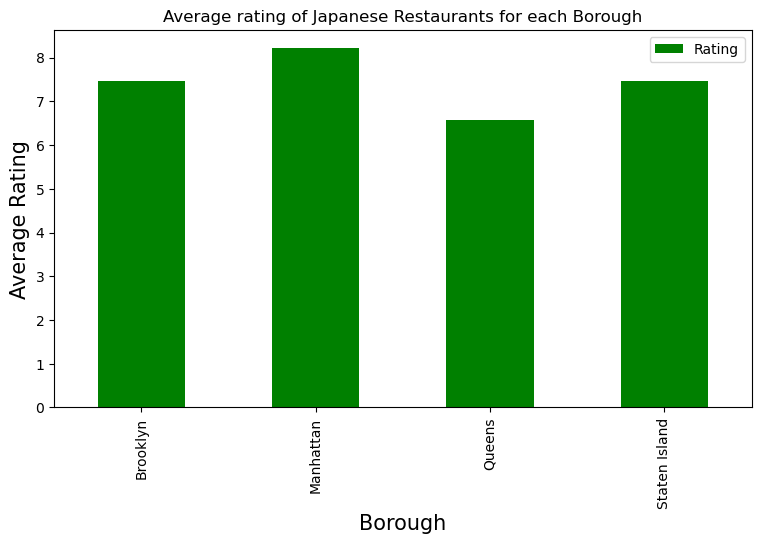

In [44]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Japanese Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
japanese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color='green')
plt.legend()
plt.show()

In [45]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
1,Boerum Hill,8.400000
5,Chelsea,8.500000
7,Cobble Hill,8.800000
8,Downtown,8.800000
9,East Village,9.250000
13,Greenwich Village,8.100000
16,Hunters Point,8.866667
18,Kensington,8.100000
19,Lenox Hill,8.400000
20,Lindenwood,8.600000


In [32]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,neighborhoods, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,7.600000
1,Brooklyn,Boerum Hill,40.685683,-73.983748,8.400000
2,Brooklyn,Brooklyn Heights,40.695864,-73.993782,7.700000
3,Staten Island,Bulls Head,40.609592,-74.159409,7.100000
4,Brooklyn,Carroll Gardens,40.680540,-73.994654,7.400000
5,Manhattan,Chelsea,40.744035,-74.003116,8.500000
6,Staten Island,Chelsea,40.594726,-74.189560,8.500000
7,Brooklyn,Clinton Hill,40.693229,-73.967843,6.600000
8,Brooklyn,Cobble Hill,40.687920,-73.998561,8.800000
9,Brooklyn,Downtown,40.690844,-73.983463,8.800000


Also, I want to shoe these restaurants in a new york city map as below.

In [33]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [34]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [35]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)